# PUC-MG - Trabalho de Conclusão de Curso

## Especialização em Inteligência Artificial e Aprendizado de Máquina - 2019/2020

### Aluno: Geraldo Tonato Leite
### Título: Identificação de emoções em textos escritos em português do Brasil

## Bibliotecas

In [51]:
#Manipulação e Análise
import pandas as pd

#NLP
import nltk
import re
from unicodedata import normalize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

#Vetorização de texto
from sklearn.feature_extraction.text import TfidfVectorizer


In [52]:
#Classificadores testados / utilizados
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

#Utilitários SKlearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV

#Métricas e estatísticas
from sklearn import metrics
import statistics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from scipy.stats import uniform
import numpy as np

#gráficos
import matplotlib.pyplot as plt

In [53]:
#Prepara para retirar stopwords e 'stematizar' em portugues
stop_words=set(stopwords.words('portuguese'))
stemmer = nltk.stem.RSLPStemmer()

# Tokenizador: utilizado para separar uma frase em palavras
tokenizer = RegexpTokenizer(r'\w+')

# Semente aleatória usada neste notebook, para garantir reprodutibilidade de resultados
random_state=501


## Funções

In [54]:
# limpeza do texto

def limpar_texto(texto):
    # Converte para minúsculas
    texto = texto.lower()
  
    # Remove acentos
    texto = normalize('NFKD', texto).encode('ASCII', 'ignore').decode('ASCII')
    
    # Remove caracteres especiais e números
    texto = re.sub(r'[^a-zA-Z_]',' ',texto)
  
    # Remove espaços extras, palavras pequenas, stopwords e realiza o stemming
    tokens = tokenizer.tokenize(texto)
    tokens = [stemmer.stem(palavra) for palavra in tokens if (len(palavra) >= 3 and palavra not in stop_words)]   
    texto = ' '.join(tokens)  

    return texto

In [55]:
#Imprime o valor no gráfico de barras
def autolabel(rects):

    for rect in rects:
        height = rect.get_height()
        plt.annotate('{0:.4f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


## Carregando os dados rotulados

In [56]:
df = pd.read_csv('treino.csv')
print('Total de registros carregados:',len(df))
# Exibe uma amostra dos dados
df.tail(10)

Total de registros carregados: 1700


,id,texto,classe
1690,1676,navio mercante encontra peça em área de buscas...,tristeza
1691,193,cozinha de restaurante argentino pega fogo em ...,medo
1692,1582,xarope com produto tóxico teria matado 24 cria...,tristeza
1693,468,"com financiamento coletivo, brasileira reforma...",alegria
1694,1109,enterro de paulo goulart será no início da tar...,tristeza
1695,8,polícia encontra cocaína escondida em boneco d...,surpresa
1696,1953,domingo no tca traz espetáculo cômico a r$ 1. ...,alegria
1697,864,mil desalojados dividem 4 chuveiros em abrigo ...,tristeza
1698,1498,manifestantes fazem ato contra reunião do g8 n...,desgosto
1699,1946,gurgel confirma existência do mensalão e apont...,raiva


In [57]:
# Distribuição das classes nos dados fornecidos
df.groupby('classe').count()

,id,texto
classe,,
alegria,156,156
desgosto,223,223
medo,189,189
neutro,461,461
raiva,70,70
surpresa,214,214
tristeza,387,387


## Explorando o dataset e preparando os textos para classificação

In [58]:
#Métricas do tamanho dos textos antes da limpeza e tratamento
tam_texto=[]
for texto in df['texto']:
    tam_texto.append(len(tokenizer.tokenize(texto)))
print("Média do tamanho dos textos (em palavras): {0:.2f} ".format(statistics.mean(tam_texto)))
print("Mediana do tamanho dos textos (em palavras): {0:.2f} ".format(statistics.median(tam_texto)))
print("Desvio padrão do tamanho dos textos (em palavras): {0:.2f}".format(statistics.stdev(tam_texto)))

Média do tamanho dos textos (em palavras): 31.29 
Mediana do tamanho dos textos (em palavras): 31.00 
Desvio padrão do tamanho dos textos (em palavras): 6.83


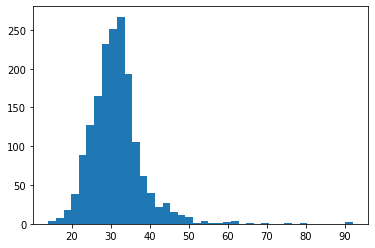

In [59]:
#Histograma do tamanho dos textos (em palavras) antes da limpeza e tratamento
plt.hist(tam_texto, bins=40)
plt.show()

In [60]:
#Limpa o texto e monta o vocabulário
vocab=set()
df['texto'] = df['texto'].apply(limpar_texto)

#Monta vocabulário
for texto in df['texto']:
    vocab.update(set(tokenizer.tokenize(texto)))   

In [61]:
#Métricas do tamanho dos textos depois da limpeza e tratamento
tam_texto=[]
for texto in df['texto']:
    tam_texto.append(len(tokenizer.tokenize(texto)))
print("Média do tamanho dos textos (em palavras): {0:.2f} ".format(statistics.mean(tam_texto)))
print("Mediana do tamanho dos textos (em palavras): {0:.2f} ".format(statistics.median(tam_texto)))
print("Desvio padrão do tamanho dos textos (em palavras): {0:.2f}".format(statistics.stdev(tam_texto)))

Média do tamanho dos textos (em palavras): 19.94 
Mediana do tamanho dos textos (em palavras): 20.00 
Desvio padrão do tamanho dos textos (em palavras): 4.01


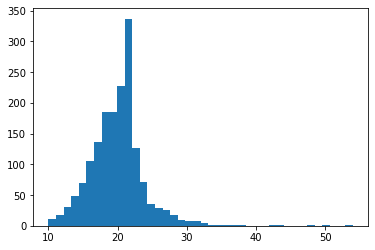

In [62]:
#Histograma do tamanho dos textos (em palavras) depois da limpeza e tratamento
plt.hist(tam_texto, bins=40)
plt.show()

In [63]:
#Tamanho e exemplo do vocabulário
print(len(vocab))
print(list(vocab)[:10])

5695
['chuv', 'sai', 'supercomput', 'edifici', 'prossegu', 'evolu', 'recontrat', 'exclusa', 'kaiow', 'narcotraf']


In [64]:
#Separa dados de treino / teste
df_treino, df_teste = train_test_split(df, test_size=0.20, stratify=df['classe'], shuffle=True, random_state=random_state)
print('Tamanho do Treino:',len(df_treino),'- Tamanho do Teste:',len(df_teste))

Tamanho do Treino: 1360 - Tamanho do Teste: 340


In [65]:
#Instancia o vetorizador TF*IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 1), vocabulary=vocab,sublinear_tf=True)

In [66]:
#Vetoriza TF-IDF os dataframes
X=vectorizer.fit_transform(df['texto'])
y=df['classe']
X_treino = vectorizer.fit_transform(df_treino['texto'])
y_treino=df_treino['classe']
X_teste= vectorizer.fit_transform(df_teste['texto'])
y_teste =  df_teste['classe']
#Imprime tipo e formato da matriz esparsa
print("Matriz TF-IDF: ", type(X), X.shape)

Matriz TF-IDF:  <class 'scipy.sparse.csr.csr_matrix'> (1700, 5695)


## Instancia os classificadores SGD, MLP e LR

In [67]:
clf_SGD = SGDClassifier(loss='modified_huber', penalty='l2', alpha=2e-3, random_state=random_state, max_iter=5, tol=None)
clf_MLP= MLPClassifier(solver='lbfgs', alpha=1e-3, hidden_layer_sizes=(70, ), random_state=random_state)
clf_LR = LogisticRegression(solver='lbfgs', multi_class='auto', class_weight='balanced', penalty='l2', C=2, random_state=random_state, tol=1e-5)

## Roda os classificadores com validação cruzada e avalia métrica alvo (F1 score macro)

In [68]:
#Roda o SGD Classifier com validação cruzada 10 fold
cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state=random_state)
results_SGD = cross_validate(clf_SGD, X_treino, y_treino, cv = cv, return_train_score=False, scoring='f1_macro')
print("F1-macro: {0:.5f} +- {1:.5f}".format( results_SGD['test_score'].mean()* 100,results_SGD['test_score'].std()* 100 ))

F1-macro: 43.69143 +- 4.06659


In [69]:
#Roda o MLP Classifier com validação cruzada 10 fold
cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state=random_state)
results_MLP = cross_validate(clf_MLP, X_treino, y_treino, cv = cv, return_train_score=False,scoring='f1_macro')
print("F1-macro: {0:.5f} +- {1:.5f}".format( results_MLP['test_score'].mean()* 100,results_MLP['test_score'].std()* 100 ))

F1-macro: 43.57803 +- 3.37117


In [70]:
#Roda o Logistic Regressor com validação cruzada 10 fold
cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state=random_state)
results_LR = cross_validate(clf_LR, X_treino, y_treino, cv = cv, return_train_score=False, scoring='f1_macro')
print("F1-macro: {0:.5f} +- {1:.5f}".format( results_LR['test_score'].mean()* 100,results_LR['test_score'].std()* 100 ))

F1-macro: 48.73940 +- 4.07137


## Otimização do classificador (regressão logística) com o Random Search

In [71]:
espaco_de_parametros = {
    "solver" : ['lbfgs', 'liblinear'],
    "tol" : uniform(1e-6, 1e-4),
    "C" : uniform(0, 5),
    "intercept_scaling" : uniform(0, 2)
}
busca = RandomizedSearchCV(estimator=LogisticRegression(multi_class='auto', class_weight='balanced', penalty='l2', random_state=random_state),
                    param_distributions=espaco_de_parametros,
                    n_iter = 64,
                    cv = cv,
                    scoring='f1_macro',      
                    random_state = random_state)
busca.fit(X_treino, y_treino)
clf_Best= busca.best_estimator_
print("Melhor modelo: ",clf_Best)
print("Melhor F1 score: ", busca.best_score_*100)

Melhor modelo:  LogisticRegression(C=0.53933802025739, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=0.678682297425889,
                   l1_ratio=None, max_iter=100, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=501, solver='lbfgs',
                   tol=5.892886039498954e-05, verbose=0, warm_start=False)
Melhor F1 score:  50.64361750226391


In [72]:
#Roda o Logistic Regressor otimizado com o RandomSearch e validação cruzada 10 fold
cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state=random_state)
results_Best = cross_validate(clf_Best, X_treino, y_treino, cv = cv, return_train_score=False, scoring='f1_macro')
print("F1-macro: {0:.5f} +- {1:.5f}".format( results_Best['test_score'].mean()* 100,results_Best['test_score'].std()* 100 ))

F1-macro: 50.64362 +- 3.63217


## Roda e avalia os classificadores com a massa de dados de teste

In [73]:
# Avalia a performance do classificador SGD, usando a massa reservada para testes
f1=list()
acuracia=list()
clf_SGD.fit(X_treino, y_treino)
y_predicted = clf_SGD.predict(X_teste)
print(metrics.classification_report(y_teste.values,y_predicted,digits=4))
f1.append(f1_score(y_teste, y_predicted, average='macro'))
acuracia.append(accuracy_score(y_teste, y_predicted))

              precision    recall  f1-score   support

     alegria     0.5000    0.1613    0.2439        31
    desgosto     0.5517    0.3556    0.4324        45
        medo     0.7500    0.3947    0.5172        38
      neutro     0.5915    0.9130    0.7179        92
       raiva     0.6250    0.3571    0.4545        14
    surpresa     0.5185    0.3256    0.4000        43
    tristeza     0.6154    0.8312    0.7072        77

    accuracy                         0.5971       340
   macro avg     0.5932    0.4769    0.4962       340
weighted avg     0.5932    0.5971    0.5610       340



In [74]:
# Avalia a performance do classificador MLP, usando a massa reservada para testes
clf_MLP.fit(X_treino, y_treino)
y_predicted = clf_MLP.predict(X_teste)
print(metrics.classification_report(y_teste.values,y_predicted,digits=4))
f1.append(f1_score(y_teste, y_predicted, average='macro'))
acuracia.append(accuracy_score(y_teste, y_predicted))

              precision    recall  f1-score   support

     alegria     0.4615    0.1935    0.2727        31
    desgosto     0.5385    0.3111    0.3944        45
        medo     0.6667    0.5263    0.5882        38
      neutro     0.6457    0.8913    0.7489        92
       raiva     0.5000    0.3571    0.4167        14
    surpresa     0.4667    0.3256    0.3836        43
    tristeza     0.6346    0.8571    0.7293        77

    accuracy                         0.6088       340
   macro avg     0.5591    0.4946    0.5048       340
weighted avg     0.5859    0.6088    0.5763       340



In [75]:
# Avalia a performance do classificador LR, usando a massa reservada para testes
clf_LR.fit(X_treino, y_treino)
y_predicted = clf_LR.predict(X_teste)
print(metrics.classification_report(y_teste.values,y_predicted,digits=4))
f1.append(f1_score(y_teste, y_predicted, average='macro'))
acuracia.append(accuracy_score(y_teste, y_predicted))

              precision    recall  f1-score   support

     alegria     0.4348    0.3226    0.3704        31
    desgosto     0.4091    0.4000    0.4045        45
        medo     0.7407    0.5263    0.6154        38
      neutro     0.6786    0.8261    0.7451        92
       raiva     0.3529    0.4286    0.3871        14
    surpresa     0.6000    0.4186    0.4932        43
    tristeza     0.6667    0.7532    0.7073        77

    accuracy                         0.6059       340
   macro avg     0.5547    0.5251    0.5318       340
weighted avg     0.6016    0.6059    0.5962       340



In [76]:
# Avalia a performance do classificador LR otimizado com RandomSearch, usando a massa reservada para testes
clf_Best.fit(X_treino, y_treino)
y_predicted = clf_Best.predict(X_teste)
print(metrics.classification_report(y_teste.values,y_predicted, digits=4))
f1.append(f1_score(y_teste, y_predicted, average='macro'))
acuracia.append(accuracy_score(y_teste, y_predicted))

              precision    recall  f1-score   support

     alegria     0.3548    0.3548    0.3548        31
    desgosto     0.4500    0.4000    0.4235        45
        medo     0.7333    0.5789    0.6471        38
      neutro     0.6697    0.7935    0.7264        92
       raiva     0.3500    0.5000    0.4118        14
    surpresa     0.5625    0.4186    0.4800        43
    tristeza     0.7308    0.7403    0.7355        77

    accuracy                         0.6059       340
   macro avg     0.5502    0.5409    0.5399       340
weighted avg     0.6061    0.6059    0.6015       340



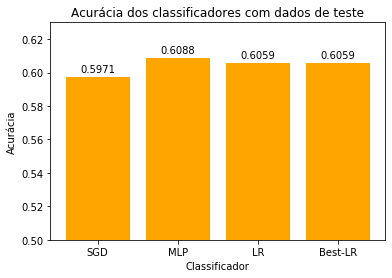

In [77]:
#Imprime o gráfico de barras da acuracia
classificadores = ['SGD', 'MLP', 'LR', 'Best-LR']
barra= plt.bar(classificadores, acuracia, color="orange")
autolabel(barra)
plt.xticks(classificadores)
plt.ylabel('Acurácia')
plt.xlabel('Classificador')
plt.ylim(.5,.63)
plt.title('Acurácia dos classificadores com dados de teste')
plt.show()

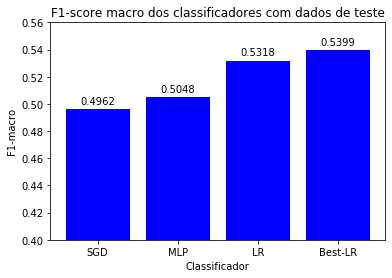

In [78]:
#Imprime o gráfico de barras do F1-macro
barra=plt.bar(classificadores, f1, color="blue")
autolabel(barra)
plt.xticks(classificadores)
plt.ylabel('F1-macro')
plt.xlabel('Classificador')
plt.ylim(.4,.56)
plt.title('F1-score macro dos classificadores com dados de teste')
plt.show()

## Classificando os registros não rotulados para o desafio


In [80]:
#Abre dataset de predição
df_class_final=pd.read_csv('teste-sem-classe.csv')

In [81]:
#Limpa o texto
df_class_final['texto'] = df_class_final['texto'].apply(limpar_texto)

#Monta vocabulário completo
for texto in df_class_final['texto']:
    vocab.update(set(tokenizer.tokenize(texto)))  
#Tamanho e exemplo do vocabulário
print(len(vocab))

6092


In [82]:
#Métricas do tamanho dos textos depois da limpeza e tratamento
tam_texto=[]
for texto in df_class_final['texto']:
    tam_texto.append(len(tokenizer.tokenize(texto)))
print("Média do tamanho dos textos (em palavras): {0:.2f} ".format(statistics.mean(tam_texto)))
print("Mediana do tamanho dos textos (em palavras): {0:.2f} ".format(statistics.median(tam_texto)))
print("Desvio padrão do tamanho dos textos (em palavras): {0:.2f}".format(statistics.stdev(tam_texto)))

Média do tamanho dos textos (em palavras): 19.96 
Mediana do tamanho dos textos (em palavras): 20.00 
Desvio padrão do tamanho dos textos (em palavras): 3.71


In [83]:
#Instancia o vetorizador TF*IDF, agora com o novo vocabulário
vectorizer = TfidfVectorizer(ngram_range=(1, 1), vocabulary=vocab,sublinear_tf=True)
#Vetoriza TF-IDF os dataframes completos e a classificar
X=vectorizer.fit_transform(df['texto'])
y=df['classe']
X_final = vectorizer.fit_transform(df_class_final['texto'])

In [84]:
#Retreina com a base completa
clf_Best.fit(X, y)

LogisticRegression(C=0.53933802025739, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=0.678682297425889,
                   l1_ratio=None, max_iter=100, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=501, solver='lbfgs',
                   tol=5.892886039498954e-05, verbose=0, warm_start=False)

In [94]:
#Realiza a previsão do dataset final
df_class_final['classe'] = clf_Best.predict(X_final)
df_class_final.groupby('classe').count()

,id,texto
classe,,
alegria,25,25
desgosto,36,36
medo,32,32
neutro,87,87
raiva,23,23
surpresa,37,37
tristeza,60,60


In [86]:
#Gera o csv final a ser enviado para o Desafio IA 2020 - Etapa PLN
df_csv_final=df_class_final[['id', 'classe']]
df_csv_final.to_csv('class_final.csv', index=False, encoding="utf-8")